## Import e init

importiamo le librerie necessarie e inizializziamo la lettura del documento SVG

In [1]:
from xml.dom import minidom

import matplotlib.pyplot as plt
from descartes.patch import PolygonPatch
import re
import math
import numpy as np

from shapely.geometry import Point, Polygon

from blueprint import *

In [2]:
doc = minidom.parse('drawing_test.svg')

## Data process

Leggiamo alcune proprietà del file:

In [3]:
dimensions = doc.getElementsByTagName('svg')[0].getAttribute('viewBox').split()
dimensions = [float(i) for i in dimensions]

BP = Blueprint(dimensions[0],dimensions[1],dimensions[2],dimensions[3])

try:
    gTranslation = doc.getElementsByTagName('g')[0].getAttribute('transform')
    gTranslation = re.search('translate\(([^\)]+)\)',gTranslation).group(1).split(',')
    xTranslation = float(gTranslation[0])
    yTranslation = float(gTranslation[1])
except:
    xTranslation = 0.0
    yTranslation = 0.0
    
BP.setTranslation(xTranslation,yTranslation)

Troviamo le uscite e le entrate. L'entrata è determinata dall'id **entrata**\_n e l'uscita da **uscita**\_n

In [4]:
entrances = {}
exits  = {}

for path in doc.getElementsByTagName('path'):
    idPath = path.getAttribute('id')
    if idPath.startswith( 'entrata' ):
        ref = entrances[idPath] = {}
    elif idPath.startswith( 'uscita' ):
        ref = exits[idPath]  = {}
    else:
        continue
    
    ref['object'] = path
    ref['cx'] = float(path.getAttribute('sodipodi:cx'))
    ref['cy'] = float(path.getAttribute('sodipodi:cy'))

Troviamo ora i muri. Tutti i muri sono i rect

In [5]:
walls = []

for rect in doc.getElementsByTagName('rect'):
    idRect = rect.getAttribute('id')

    x = float(rect.getAttribute('x'))
    y = float(rect.getAttribute('y'))
    width = float(rect.getAttribute('width'))
    height = float(rect.getAttribute('height'))
    
    matrixTransformation = False
    scaleTransformation  = False
    if rect.hasAttribute('transform'):
        m = re.search('matrix\(([^\)]+)\)', rect.getAttribute('transform'))
        if m:
            matrixTransformation = m.group(1).split(',')
        s = re.search('scale\(([^\)]+)\)', rect.getAttribute('transform'))
        if s:
            scaleTransformation = s.group(1).split(',')
    
    wall = Wall(x,y,width,height,matrixTransformation,scaleTransformation)
    wall.setID(idRect)
    
    walls.append(wall)

Ed infine, più o meno nello stesso modo, troviamo i punti di attrazione (circle):

In [6]:
attractionPoints = []

for circle in doc.getElementsByTagName('circle'):
    idCircle = circle.getAttribute('id')

    x = float(circle.getAttribute('cx'))
    y = float(circle.getAttribute('cy'))
    r = float(circle.getAttribute('r'))
    
    circle = attractionPoint(x,y,r)
    circle.setID(idCircle)
    
    attractionPoints.append(circle)

## Init sniffing paths
Per ogni attraction point ci deve essere una pollicinata per arrivarci, altrimenti il walker sarà attratto attraverso i muri

In [22]:
BP.setCellDimension(20)
BP.defineMaze(walls)

In [23]:
# colletting uniformed points
points = {}

for entranceID,entrance in entrances.items():
    points[entranceID] = entrance
for exitID,exit in exits.items():
    points[exitID] = exit
for ap in attractionPoints:
    points[ap.id] = {'object':ap,'cx':ap.cx,'cy':ap.cy}

In [24]:
for i,idStart in enumerate(points.keys()):
    for j in range(i+1,len(points)):
        idEnd = list(points.keys())[j]
        idPath = idStart + "-" + idEnd
        BP.calcPath(points[idStart],points[idEnd],idPath)

	entrata-uscita: finding best path...
	entrata-circle4151: finding best path...
	uscita-circle4151: finding best path...


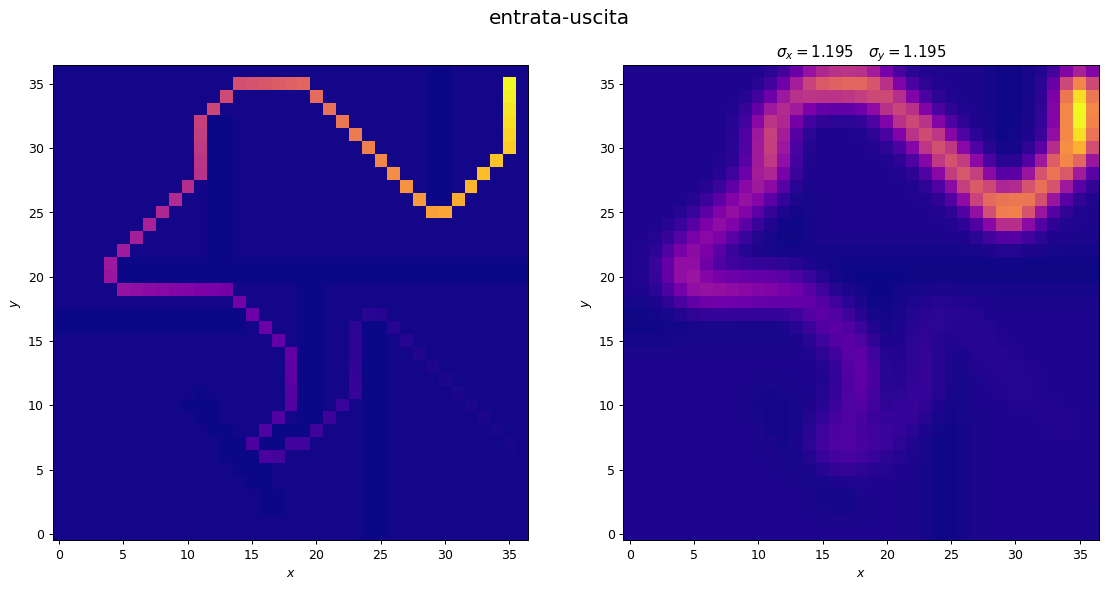

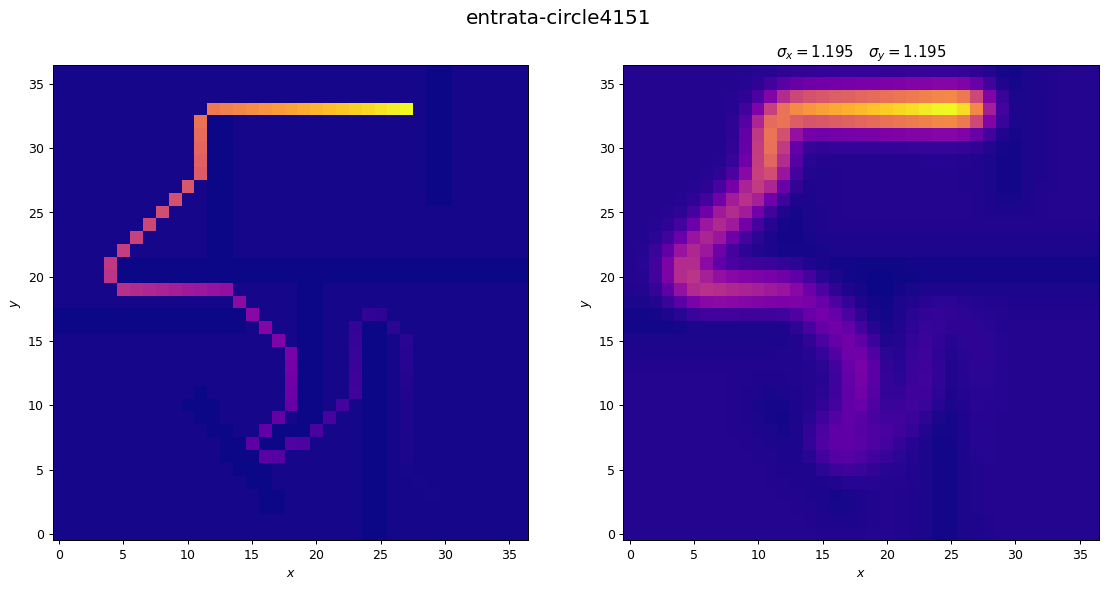

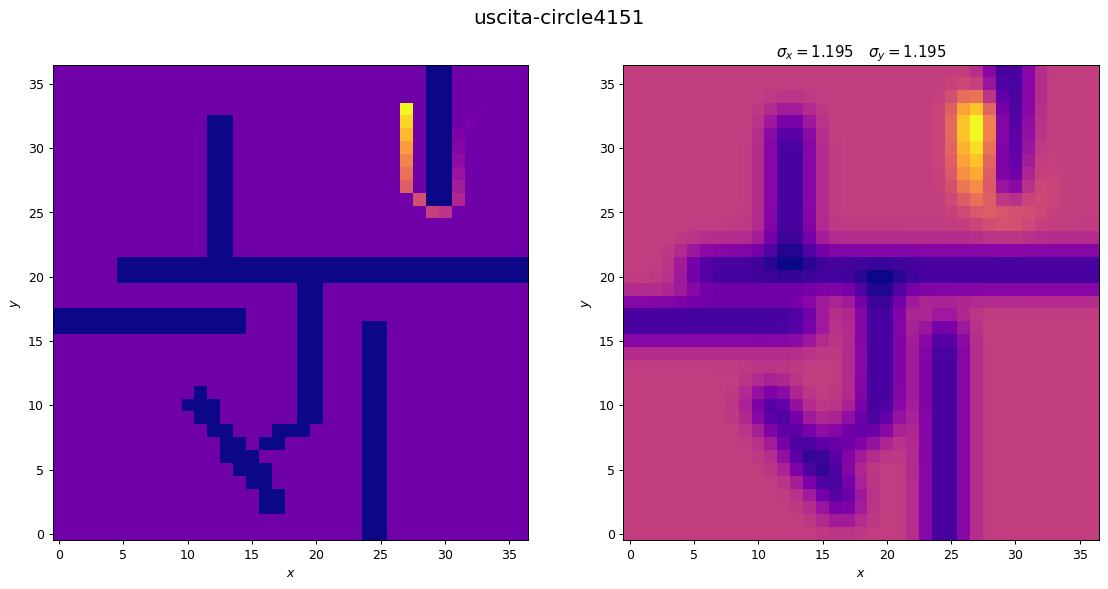

In [25]:
for key,path in BP.paths.items():
    plotSniffingMap(BP.maze,path)

# Walking

In [26]:
import random
from shapely.geometry.point import Point

def probDistr(n,predictability = 0.45):
    arr = []
    for x in range(1,n+1):
        p = -((2.5*predictability)**3)*(x-1)+10
        if p<0:
            p=0
        arr.append(p)
    return [float(i)/sum(arr) for i in arr]

class Walker:
    
    pathway        = []
    steps          = 0
    predictability = 0.45
    currentPath    = None
    maxSteps       = 10000
    
    
    def __init__(self,paths,name):
        self.id = name
        self.paths = paths
        
    def startWalking(self):
        for path in self.paths:
            self.currentPosition = path.start
            self.updatePosition()
            self.currentPath = path
            self.followSniffingPath()
            
    def getRandomDirection(self,path=None):
        if not path:
            path = self.currentPath
        
        # get points around the current pos        
        a = np.ones((3,3))*-1
        for i,r in enumerate(a):
            for j,c in enumerate(r):
                if i==1 and j==1:
                    continue
                try:
                    toMapX = -1+j+self.currentPosition[0]
                    toMapY = 1-i+self.currentPosition[1]
                    a[i][j] = path.sniffingMap[toMapX][toMapY]
                except IndexError:
                    a[i][j] = -10
        
        # get the random direction based on the predicibility
        n = np.random.choice(np.arange(1, 9), p=probDistr(8,0.1))        
        largest = a.flatten().argsort()[-n:][::-1]
        
        iNeg = len(largest)
        for ix,i in enumerate(largest):
            rowI = int(i/3)
            colI = i%3
            val = a[rowI][colI]
            if val < 0:
                iNeg = ix
                break

        possibleDirections = largest[:iNeg] # avoid negative numbers
        selectedDirection = possibleDirections[random.randint(0, len(possibleDirections)-1)]
        
        return (int(selectedDirection/3),selectedDirection%3)
    
    def updatePosition(self,direction = (1,1)):
        self.currentPosition = (self.currentPosition[0]-1+direction[1],
                                self.currentPosition[1]+1-direction[0])
        self.pathway.append(self.currentPosition)
            
    def followSniffingPath(self):
        i = 0
        while not Point(self.currentPosition[0],self.currentPosition[1])\
                        .within(Point(self.currentPath.end[0],self.currentPath.end[1]).buffer(5.0)):
            
            if i>self.maxSteps:
                print("reached max step for a walker")
                break
            direction = (self.getRandomDirection())
            self.updatePosition(direction)
            i+=1
        

In [27]:
walker = Walker([BP.paths['entrata-uscita']],'pietro')

In [28]:
walker.startWalking()
print(walker.currentPosition)

(35, 5)


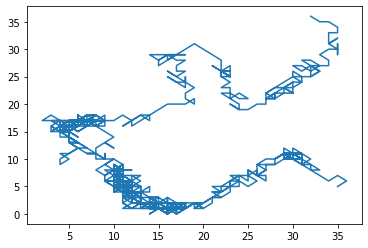

In [29]:
plt.plot(*zip(*walker.pathway))

In [15]:
Point(0, 0).within(Point(3,3).buffer(3.0))

False

In [16]:
def plotWalkerPathway(maze,walker,title=None):
    a = np.copy(maze)

    print(a.shape)
    for i, (x, y) in enumerate(walker.pathway):
        a[x][y] = 2

    figure = plt.figure(figsize=[15, 15], dpi=90)

    plt.imshow(np.rot90(a), cmap='Dark2', interpolation='nearest')
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.gca().invert_yaxis()

    plt.show()

(29, 29)


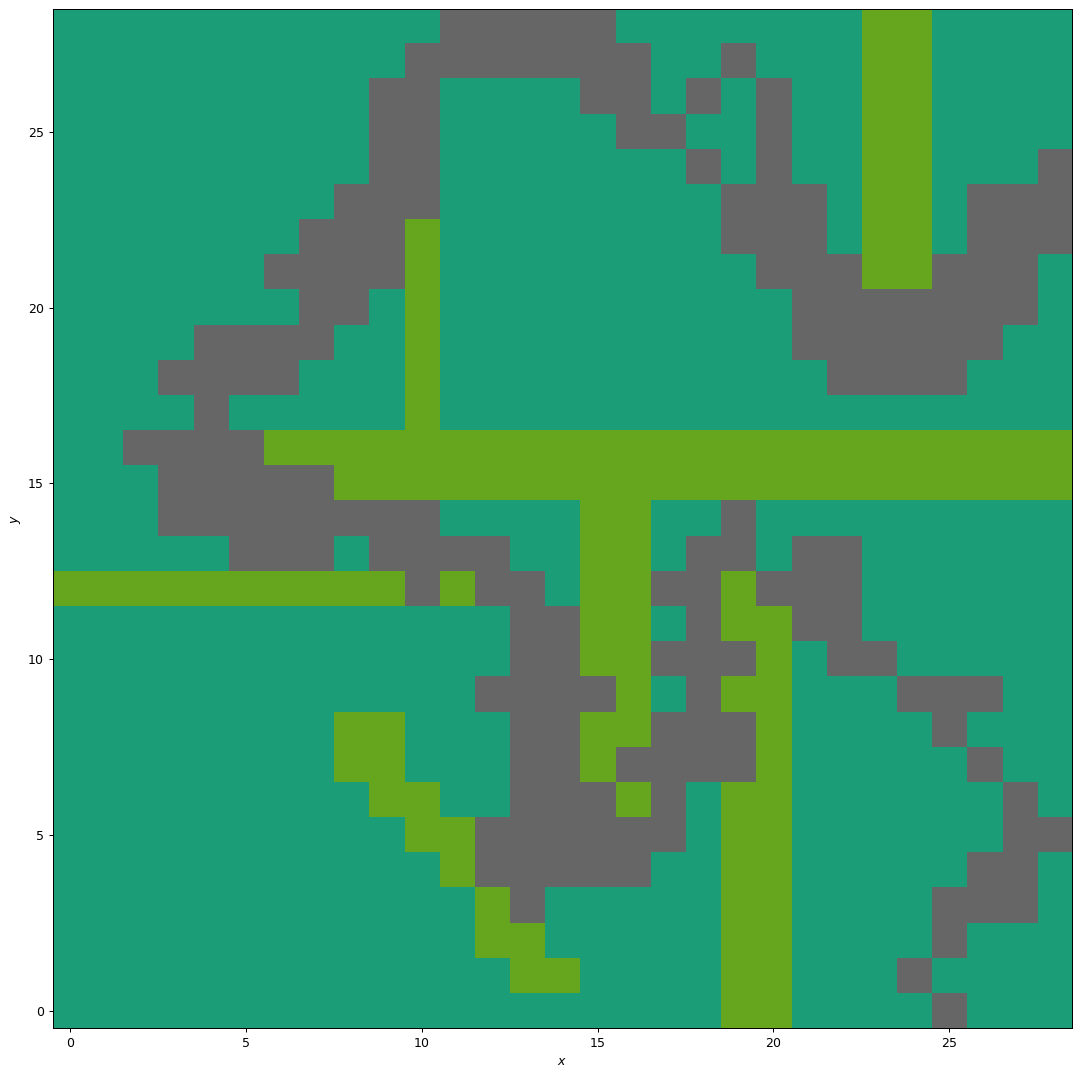

In [17]:
plotWalkerPathway(BP.maze,walker)